Ler [Ajuste de hiperparâmetros com o painel HParams](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)

# Reading the Data

In [1]:
import numpy as np

with open('data/X_train_tdidf_cedae.npy', 'rb') as f:
    X_train = np.load(f)
    
with open('data/y_train_tdidf_cedae.npy', 'rb') as f:
    y_train = np.load(f)
    
with open('data/X_test_tdidf_cedae.npy', 'rb') as f:
    X_test = np.load(f)
    
with open('data/y_test_tdidf_cedae.npy', 'rb') as f:
    y_test = np.load(f)

In [2]:
X_train.shape[1]

344

# Usando Keras Tuning

In [18]:
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

input_shape = (X_train.shape[1],)
number_of_intent_classes = y_train.shape[1]
max_qt_neurons = 10000 

def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=input_shape[0],
                                            max_value=max_qt_neurons,
                                            step=100),
                               activation='relu'))
    model.add(Dense(number_of_intent_classes, activation='softmax'))
    model.compile(
        optimizer = Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        # loss='categorical_crossentropy',
        loss="cosine_similarity",
        metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    max_epochs=100,
    objective='val_accuracy',
    seed=42,
    executions_per_trial=1,
    directory='tuner-results',
    project_name='1º-tfidf'
)

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 866, 'max_value': 10000, 'step': 100, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 866, 'max_value': 10000, 'step': 100, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 7 Complete [00h 01m 24s]
val_accuracy: 0.021276595070958138

Best val_accuracy So Far: 0.0936170220375061
Total elapsed time: 00h 04m 43s

Search: Running Trial #8

Hyperparameter    |Value             |Best Value So Far 
num_layers        |9                 |3                 
units_0           |8466              |9666              
units_1           |5266              |1266              
learning_rate     |0.01              |0.0001            
units_2           |3066              |2866              
units_3           |9066              |3666              
units_4           |8366              |5366              
units_5           |3066              |9366              
units_6           |7366              |4966              
units_7           |9366              |5166              
units_8           |5566              |4666              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4           

KeyboardInterrupt: 

In [8]:
tuner.results_summary()

Results summary
Results in tuner-results/embeddings-tf-idf
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 1474
units_1: 1186
learning_rate: 0.001
units_2: 66
units_3: 194
units_4: 514
units_5: 290
units_6: 738
units_7: 962
units_8: 1058
units_9: 34
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: fe178ad7dc162a1493069de251a27ff4
Score: 0.4765957474708557
Trial summary
Hyperparameters:
num_layers: 2
units_0: 450
units_1: 1154
learning_rate: 0.001
units_2: 674
units_3: 1282
units_4: 1282
units_5: 130
units_6: 482
units_7: 1186
units_8: 866
units_9: 1378
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 754caaac52e4adc62c461bc2987dbae8
Score: 0.4706382989883423
Trial summary
Hyperparameters:
num_layers: 2
units_0: 482
units_1: 1346
learning_rate: 0.001
units_2: 450
units_3: 706
units_4: 386
units_5: 546
units_6: 162
units_7: 994
uni

# Using Best Tuning

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def set_model(input_shape, number_of_intent_classes):
    # Initializes a sequential model
    model = Sequential()

    # 1º layer
    model.add(Dense(input_shape[0], activation='relu', input_shape = input_shape,
                    name='input_layer'))

    # model.add(Dropout(0.1))
    
     # 2º layer
    model.add(Dense(input_shape[0], activation='relu', name='layer_2'))

    # Output layer
    model.add(Dense(number_of_intent_classes,
                    activation='softmax', name='output_layer'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
               loss='categorical_crossentropy',
               # loss="cosine_similarity",
               metrics=['accuracy'])
    
    return model

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split


input_shape = (X_train.shape[1],)
number_of_intent_classes = y_train.shape[1]

model = set_model(input_shape, number_of_intent_classes)

In [6]:
history = model.fit(X_train, y_train, 
                 epochs=100, 
                 verbose=False, 
                 batch_size=100, 
                 validation_data=(X_test, y_test))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [7]:
_, acc = model.evaluate(X_test, y_test)
print("Acurácia: ", round(acc*100, 2), "%")

4/4 [==============================] - 0s 2ms/step - loss: 1.1048 - accuracy: 0.7075
Acurácia:  70.75 %


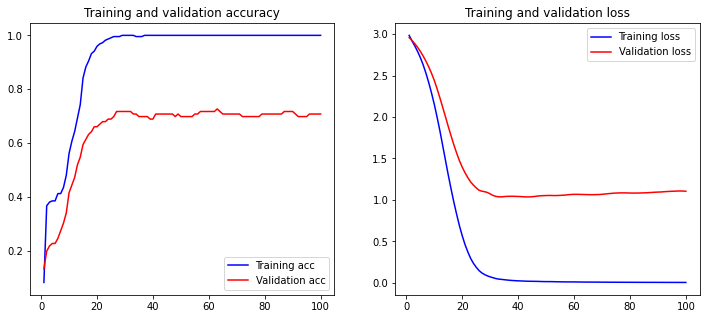

In [8]:
plot_history(history)

In [9]:
model.save("nlp_models/cedae-bestModel-70.75acc-2020-02-01.h5")